# Раздел 1: Обучение CTC ASR модели

In [ ]:
!pip install evaluate -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torchaudio

import torch
import torch.nn as nn
from evaluate import load
import torch.nn.functional as F


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")


Используется устройство: cpu


## Часть 1: Реализация Conformer энкодера

В этой части вам нужно реализовать аудио энкодер на основе архитектуры Conformer из статьи "Conformer: Convolution-augmented Transformer for Speech Recognition" (https://arxiv.org/abs/2005.08100).


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape

        q = self.q_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        out = torch.matmul(attention, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        return self.out_linear(out)

class PositionalEncoding(nn.Module):
    """
    Синусоидальные позиционные кодировки как в оригинальном Transformer
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

class ConvolutionModule(nn.Module):
    """
    Сверточный модуль Conformer'а
    Состоит из pointwise conv -> GLU -> depthwise conv -> BatchNorm -> Swish -> pointwise conv
    """
    def __init__(self, d_model, kernel_size=31, dropout=0.1):
        super().__init__()
        assert kernel_size % 2 == 1, "Kernel size должен быть нечетным"

        # <YOUR CODE>

    def forward(self, x):
        # x: (batch, seq_len, d_model)

        # <YOUR CODE>

        return x  # (batch, seq_len, d_model)

class FeedForwardModule(nn.Module):
    def __init__(self, d_model, expansion_factor=4, dropout=0.1):
        super().__init__()
        # <YOUR CODE>

    def forward(self, x):
        return x


Реализуйте основной блок Conformer'a

In [ ]:
class ConformerBlock(nn.Module):
    """
    Полный Conformer блок согласно оригинальной статье:
    FFN -> Multi-Head Attention -> Conv -> FFN
    С residual connections и layer normalization после каждого модуля
    """
    def __init__(self, d_model, num_heads, conv_kernel_size=31, expansion_factor=4, dropout=0.1):
        super().__init__()

        # <YOUR CODE>

    def forward(self, x):

        # <YOUR CODE>

        return x


Соберите реализованные модули в одном ConformerEncoder модуле

In [ ]:
class ConformerEncoder(nn.Module):
    """
    Полный Conformer энкодер для обработки аудио признаков
    Состоит из:
    - Понижения размерности (2 Conv2d слоя)
    - Линейного проектирования
    - Позиционных кодировок
    - Conformer блоков
    - Финального линейного слоя
    """
    def __init__(self, input_dim=80, d_model=256, num_layers=6, num_heads=4,
                 conv_kernel_size=31, dropout=0.1, num_classes=30):
        super().__init__()

        # <YOUR CODE>

    def forward(self, x):
        # x: (batch, time, features)

        # <YOUR CODE>

        return x  # (batch, time, num_classes)


Инициализация вашего Conformer'a

In [ ]:
encoder = ConformerEncoder(
    input_dim=80,
    d_model=256,
    num_layers=4,
    num_heads=4,
    num_classes=30
).to(device)

batch_size, time_steps, features = 2, 100, 80
test_input = torch.randn(batch_size, time_steps, features).to(device)

with torch.no_grad():
    test_output = encoder(test_input)

print(f"Входная форма: {test_input.shape}")
print(f"Выходная форма: {test_output.shape}")
print(f"Количество параметров энкодера: {sum(p.numel() for p in encoder.parameters()):,}")


## Часть 2: Реализация CTC Loss функции

Connectionist Temporal Classification (CTC) - это функция потерь для se12seq задач, где выравнивание между входом и выходом неизвестно. Вам нужно реализовать CTC loss с помощью алгоритма прямого-обратного распространения и сравнить с реализацией из PyTorch.

In [ ]:
class CTCLoss(nn.Module):
    def __init__(self, blank=0):
        super().__init__()
        self.blank = blank

    def forward(self, log_probs, targets, input_lengths, target_lengths):
        """
        log_probs: (T, N, C) - логарифмы вероятностей [время, батч, классы]
        targets: (N, S) - целевые последовательности
        input_lengths: (N,) - длины входных последовательностей
        target_lengths: (N,) - длины целевых последовательностей
        """

        T, N, C = log_probs.shape
        S = targets.shape[1]
        total_loss = 0.0

        for i in range(N):
            input_len = min(input_lengths[i].item(), T)
            target_len = target_lengths[i].item()

            if target_len == 0:
                # Специальный случай: пустая целевая последовательность
                loss_i = self._ctc_loss_empty_target(log_probs[:input_len, i, :])
            else:
                log_probs_i = log_probs[:input_len, i, :]  # (input_len, C)
                targets_i = targets[i, :target_len]        # (target_len,)
                loss_i = self._ctc_loss_single(log_probs_i, targets_i, input_len, target_len)

            total_loss += loss_i

        return total_loss / (N * S)

    def _ctc_loss_empty_target(self, log_probs):
        """CTC loss для пустой целевой последовательности"""
        blank_log_probs = log_probs[:, self.blank]  # (T,)
        return -torch.sum(blank_log_probs)

    def _ctc_loss_single(self, log_probs, targets, input_len, target_len):
        """Вычисление CTC loss для одного примера с помощью forward-backward algorithm"""

        # Создаем расширенную целевую последовательность с blank токенами
        extended_targets = self._create_extended_targets(targets, target_len)
        extended_len = len(extended_targets)

        alpha = torch.full((input_len, extended_len), -1e9, device=log_probs.device)

        alpha[0, 0] = log_probs[0, extended_targets[0]]  # начинаем с первого blank
        if extended_len > 1:
            alpha[0, 1] = log_probs[0, extended_targets[1]]  # или с первого символа

        for t in range(1, input_len):
            for s in range(extended_len):
                # Текущая вероятность
                current_log_prob = log_probs[t, extended_targets[s]]

                # Вычисляем сумму вероятностей путей, ведущих в текущее состояние
                # <YOUR CODE>

        # Вероятность последовательности - сумма по последним двум состояниям
        # (последний символ или последний blank)
        if extended_len > 1:
            final_prob = self._log_sum_exp(alpha[input_len-1, extended_len-1],
                                           alpha[input_len-1, extended_len-2])
        else:
            final_prob = alpha[input_len-1, extended_len-1]

        return -final_prob

    def _create_extended_targets(self, targets, target_len):
        """Создает расширенную целевую последовательность с blank токенами"""
        extended = [self.blank]
        for target in targets[:target_len]:
            extended.append(target.item())
            extended.append(self.blank)
        return torch.tensor(extended, device=targets.device, dtype=torch.long)

    def _log_sum_exp(self, a, b):
        """Стабильное вычисление log(exp(a) + exp(b))"""
        if a == -float('inf') and b == -float('inf'):
            return -float('inf')
        max_val = max(a, b)
        return max_val + torch.log(torch.exp(a - max_val) + torch.exp(b - max_val))


Сравнение с pytorch реализацией

In [ ]:
T, N, C = 50, 4, 10  # время, batch size, классы
target_length = 5

logits_0 = torch.randn(T, N, C, requires_grad=True, device=device)
logits_1 = torch.clone(logits_0).detach().requires_grad_(True)

log_probs_0 = F.log_softmax(logits_0, dim=-1)
log_probs_1 = F.log_softmax(logits_1, dim=-1)

targets = torch.randint(1, C, (N, target_length), device=device)
input_lengths = torch.full((N,), T, dtype=torch.long, device=device)
target_lengths = torch.full((N,), target_length, dtype=torch.long, device=device)

our_ctc = CTCLoss(blank=0)
our_loss = our_ctc(log_probs_0, targets, input_lengths, target_lengths)

torch_ctc = nn.CTCLoss(blank=0, reduction='mean')
torch_loss = torch_ctc(log_probs_1, targets, input_lengths, target_lengths)

print("Сравнение CTC Loss реализаций:")
print(f"Ваша реализация: {our_loss.item():.6f}")
print(f"PyTorch реализация: {torch_loss.item():.6f}")
print(f"Разница: {abs(our_loss.item() - torch_loss.item()):.6f}")

our_loss.backward()
our_grad = logits_0.grad.clone()

torch_loss.backward()
torch_grad = logits_1.grad.clone()

grad_diff = torch.mean(torch.abs(our_grad - torch_grad))
print(f"Средняя разница градиентов: {grad_diff.item():.6f}")


Сравнение CTC Loss реализаций:
Ваша реализация: 20.292530
PyTorch реализация: 20.292530
Разница: 0.000000
Средняя разница градиентов: 0.000000


## Часть 3: Обучение модели на LibriSpeech

В этой части вам нужно обучить вашу реализацию Conformer энкодера с вашим CTC loss'ом на датасете LibriSpeech (сабсет train-clean-100)

In [ ]:
class LibriSpeechProcessor:
    def __init__(self, sample_rate=16000, n_mels=80, win_length=400, hop_length=160, n_fft=512):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.win_length = win_length
        self.hop_length = hop_length
        self.n_fft = n_fft

        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_mels=n_mels,
            win_length=win_length,
            hop_length=hop_length,
            n_fft=n_fft
        )

        self.char_to_idx = {'_': 0}  # blank token для CTC
        self.idx_to_char = {0: '_'}

    def build_vocabulary(self, dataset):
        chars = set()
        for i in tqdm(range(len(dataset))):
            _, _, transcript, _, _, _ = dataset[i]
            text = transcript.lower()
            chars.update(text)

        for i, char in enumerate(sorted(chars), 1):
            self.char_to_idx[char] = i
            self.idx_to_char[i] = char

        print(f"Построен словарь из {len(self.char_to_idx)} символов: {''.join(sorted(chars))}")
        return self.char_to_idx

    def audio_to_features(self, waveform):
        # waveform: (1, num_samples)

        mel_spec = self.mel_transform(waveform)

        mel_spec = torch.log(torch.clamp(mel_spec, min=1e-10))

        # (n_mels, time) -> (time, n_mels)
        mel_spec = mel_spec.squeeze(0).transpose(0, 1)

        return mel_spec

    def text_to_indices(self, text):
        text = text.lower()
        return [self.char_to_idx[char] for char in text if char in self.char_to_idx]

    def indices_to_text(self, indices):
        return ''.join([self.idx_to_char[idx.item()] if idx.item() in self.idx_to_char else ''
                       for idx in indices])


Загрузим сабсеты датасета LibriSpeech для тренировки, валидации и теста

In [ ]:
data_dir = "./"

train_dataset = torchaudio.datasets.LIBRISPEECH(
    root=data_dir,
    url="train-clean-100",
    download=True
)

dev_dataset = torchaudio.datasets.LIBRISPEECH(
    root=data_dir,
    url="dev-clean",
    download=True
)

test_dataset = torchaudio.datasets.LIBRISPEECH(
    root=data_dir,
    url="test-clean",
    download=True
)


100%|██████████| 5.95G/5.95G [03:46<00:00, 28.2MB/s]
100%|██████████| 322M/322M [00:12<00:00, 26.7MB/s]
100%|██████████| 331M/331M [00:12<00:00, 26.7MB/s]


In [ ]:
print(f"Размер тренировочного датасета (train-clean-100): {len(train_dataset)}")
print(f"Размер валидационного датасета (dev-clean): {len(dev_dataset)}")
print(f"Размер тестового датасета (test-clean): {len(test_dataset)}")

waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = train_dataset[0]
print(f"\nПример данных:")
print(f"Waveform shape: {waveform.shape}, Sample rate: {sample_rate}")
print(f"Транскрипция: '{transcript}'")
print(f"Speaker ID: {speaker_id}, Chapter ID: {chapter_id}, Utterance ID: {utterance_id}")

processor = LibriSpeechProcessor()
processor.build_vocabulary(train_dataset)

print(f"Пример транскрипции: {transcript}")
print(f"Индексы: {processor.text_to_indices(transcript)[:20]}...")


Размер тренировочного датасета (train-clean-100): 28539
Размер валидационного датасета (dev-clean): 2703
Размер тестового датасета (test-clean): 2620

Пример данных:
Waveform shape: torch.Size([1, 225360]), Sample rate: 16000
Транскрипция: 'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK'
Speaker ID: 103, Chapter ID: 1240, Utterance ID: 0


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

  0%|          | 0/28539 [00:00<?, ?it/s]

Построен словарь из 29 символов:  'abcdefghijklmnopqrstuvwxyz
Пример транскрипции: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK
Индексы: [5, 10, 3, 18, 22, 7, 20, 1, 17, 16, 7, 1, 15, 11, 21, 21, 23, 21, 1, 20]...


Класс, наследованный от torch.utils.data.Dataset для формирования батчей

In [ ]:
class LibriSpeechTorchAudioDataset(torch.utils.data.Dataset):
    def __init__(self, librispeech_dataset, processor, max_audio_length=16000*15):
        self.dataset = librispeech_dataset
        self.processor = processor
        self.max_audio_length = max_audio_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = self.dataset[idx]

        if sample_rate != self.processor.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.processor.sample_rate)
            waveform = resampler(waveform)

        if waveform.shape[1] > self.max_audio_length:
            waveform = waveform[:, :self.max_audio_length]

        features = self.processor.audio_to_features(waveform)

        text_indices = self.processor.text_to_indices(transcript)

        return {
            'features': features,
            'labels': torch.tensor(text_indices, dtype=torch.long),
            'audio_length': features.shape[0],
            'label_length': len(text_indices),
            'waveform': waveform,
            'transcript': transcript,
            'speaker_id': speaker_id
        }


In [ ]:
def collate_fn(batch):
    """батчинг последовательностей разной длины"""
    features = [item['features'] for item in batch]
    labels = [item['labels'] for item in batch]

    features_padded = torch.nn.utils.rnn.pad_sequence(features, batch_first=True)
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

    audio_lengths = torch.tensor([item['audio_length'] for item in batch])
    label_lengths = torch.tensor([item['label_length'] for item in batch])

    waveforms = [item['waveform'] for item in batch]
    transcripts = [item['transcript'] for item in batch]
    speaker_ids = [item['speaker_id'] for item in batch]

    return {
        'features': features_padded,
        'labels': labels_padded,
        'audio_lengths': audio_lengths,
        'label_lengths': label_lengths,
        'waveforms': waveforms,
        'transcripts': transcripts,
        'speaker_ids': speaker_ids
    }


In [ ]:
train_torchaudio_dataset = LibriSpeechTorchAudioDataset(train_dataset, processor)
dev_torchaudio_dataset = LibriSpeechTorchAudioDataset(dev_dataset, processor)
test_torchaudio_dataset = LibriSpeechTorchAudioDataset(test_dataset, processor)

print(f"Тренировочные данные (train-clean-100): {len(train_torchaudio_dataset)} samples")
print(f"Валидационные данные (dev-clean): {len(dev_torchaudio_dataset)} samples")
print(f"Тестовые данные (test-clean): {len(test_torchaudio_dataset)} samples")


Тренировочные данные (train-clean-100): 28539 samples
Валидационные данные (dev-clean): 2703 samples
Тестовые данные (test-clean): 2620 samples


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_torchaudio_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

dev_loader = torch.utils.data.DataLoader(
    dev_torchaudio_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_torchaudio_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)


In [ ]:
print("\nПроверка батчей из каждого датасета:")
for loader, name in zip([train_loader, dev_loader, test_loader],
                        ["train-clean-100", "dev-clean", "test-clean"]):
    test_batch = next(iter(loader))
    print(f"{name}: features {test_batch['features'].shape}, "
          f"labels {test_batch['labels'].shape}, "
          f"audio_lengths {test_batch['audio_lengths'][:3]}...")



Проверка батчей из каждого датасета:
train-clean-100: features torch.Size([8, 1501, 80]), labels torch.Size([8, 282]), audio_lengths tensor([ 278, 1290, 1451])...
dev-clean: features torch.Size([8, 1501, 80]), labels torch.Size([8, 362]), audio_lengths tensor([ 586,  482, 1249])...
test-clean: features torch.Size([8, 1056, 80]), labels torch.Size([8, 158]), audio_lengths tensor([1044,  328,  663])...


Напишите свой код тренировки ASR модели, основанной на вашей Conformer архитектуре, с вашим CTC лоссом (или с torch CTC лоссом, если свой реализовать не удалось)

In [ ]:
model = ConformerEncoder(
    input_dim=processor.n_mels,
    d_model=256,
    num_layers=4,
    num_heads=4,
    num_classes=len(processor.char_to_idx),
    dropout=0.1
).to(device)

# <YOUR CODE>


Валидация модели, подсчёт метрики WER

In [ ]:
def greedy_decode_ctc(log_probs, processor):
    # log_probs: (time, classes)
    predictions = torch.argmax(log_probs, dim=-1)

    collapsed = []
    prev = -1
    for p in predictions:
        if p != prev:
            if p != 0:  # не blank
                collapsed.append(p)
            prev = p

    return torch.tensor(collapsed, device=log_probs.device)


In [ ]:
model.eval()

predictions = []
references = []
total_loss = 0
num_batches = 0

with torch.no_grad():
    for i, batch in enumerate(test_loader):

        features = batch['features'].to(device)
        labels = batch['labels'].to(device)
        audio_lengths = batch['audio_lengths'].to(device)
        label_lengths = batch['label_lengths'].to(device)
        transcripts = batch['transcripts']

        logits = model(features)
        log_probs = F.log_softmax(logits, dim=-1).transpose(0, 1)

        for j in range(logits.shape[0]):
            sample_log_probs = log_probs[j]  # (time, classes)
            predicted_indices = greedy_decode_ctc(sample_log_probs, processor)
            predicted_text = processor.indices_to_text(predicted_indices)

            predictions.append(predicted_text)
            references.append(transcripts[j])


In [ ]:
wer_metric = load("wer")
wer = wer_metric.compute(predictions=predictions, references=references)

print(f"Word Error Rate: {wer:.4f} ({wer*100:.2f}%)")


## Критерии оценивания:

#### Часть 1
- 2 балла - Conformer реализован верно, согласно статье
- 1 балл - Conformer реализован верно, но есть небольшие расхождения со статьёй (например использованы другие активации)
- 0 баллов - Архитектура реализована неверно

#### Часть 2
- 3 балла - CTC loss реализован верно и значения на тестовых тензорах равны реализации из torch
- 2 балла - CTC loss реализован верно, но его значения отличаются от torch реализации (менее чем на 10%)
- 1 балл - Идейно CTC loss реализован верно, но значительно отличается от torch реализации (возможно есть баг). Оценку "идейности" остаётся на совести проверяющего
- 0 баллов - CTC loss не реализован или реализован неверно

#### Часть 3
- 3 балла - Удалось достичь WER на сабсете test-clean <= 5%
- 2 балла - Удалось достичь WER на сабсете test-clean <= 10%
- 1 балл - Удалось достичь WER на сабсете test-clean <= 15%
- 0 баллов - Не удалось достичь WER на сабсете test-clean <= 15%
- +1 доп балл, если был использован самописный CTC loss

# Раздел 2: Адаптация обученной ASR модели под домен

In [ ]:
!pip install kenlm datasets==3.6.0 -qq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.5/427.5 kB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.6 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

import kenlm

from huggingface_hub import login
from datasets import load_dataset


Загрузка и визуализация датасета аудио с фразами из медицинского домена

In [ ]:
login()

Вам нужно получить доступ к датасету на его странице https://huggingface.co/datasets/ekacare/eka-medical-asr-evaluation-dataset

In [ ]:
medical_dataset = load_dataset('ekacare/eka-medical-asr-evaluation-dataset', 'en', split='test')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

Some datasets params were ignored: ['default_preview_rows']. Make sure to use only valid params for the dataset builder and to have a up-to-date version of the `datasets` library.
Some datasets params were ignored: ['default_preview_rows']. Make sure to use only valid params for the dataset builder and to have a up-to-date version of the `datasets` library.


en/test-00000.parquet:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

en/test-00001.parquet:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

en/test-00002.parquet:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

en/test-00003.parquet:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

en/test-00004.parquet:   0%|          | 0.00/32.1M [00:00<?, ?B/s]

en/test-00005.parquet:   0%|          | 0.00/60.2M [00:00<?, ?B/s]

en/test-00006.parquet:   0%|          | 0.00/63.1M [00:00<?, ?B/s]

en/test-00007.parquet:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/3619 [00:00<?, ? examples/s]

In [ ]:
print(f"Количество аудио: {len(medical_dataset)}")


Количество аудио: 3619


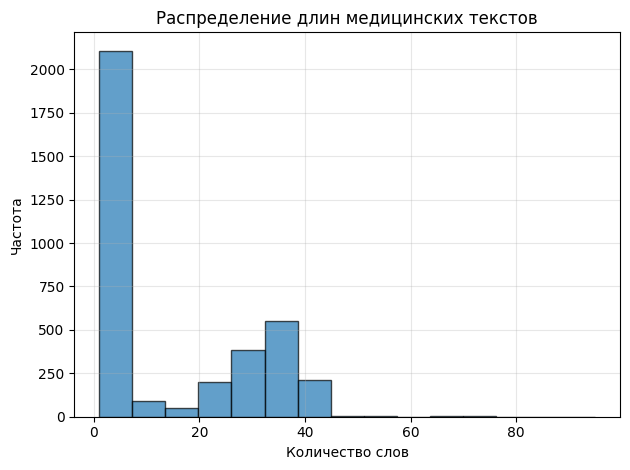

In [ ]:
text_lengths = [len(t.split()) for t in medical_dataset["text"]]

plt.hist(text_lengths, bins=15, alpha=0.7, edgecolor='black')
plt.title('Распределение длин медицинских текстов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
for i in range(3):
    print(f"Пример {i+1}:")
    print(f"  {medical_dataset['text'][i]}")
    print()


Пример 1:
  not having adequate rest. Okay okay. So that continues for better part of the day. Hmm, hmm, hmm. Then

Пример 2:
  2 times in a day, please have, an antibiotic named azithromycin.

Пример 3:
  500 mg. Also, Because you're feeling weak. Take Zincovit once in a day.



Посчитайте WER вашей предобученной модели из Раздела 1 на медицинских данных

In [ ]:
def evaluate(model, processor, samples):
    predictions = []
    references = []

    model.eval()

    with torch.no_grad():
        for i, sample in enumerate(samples):
            audio_array = sample['audio']['array']
            sample_rate = sample['audio']['sampling_rate']
            reference_text = sample['text']

            features = processor.audio_to_features(audio_array).unsqueeze(0).to(device)

            logits = model(features)
            log_probs = F.log_softmax(logits, dim=-1).squeeze(0)

            predicted_indices = greedy_decode_ctc(log_probs)
            predicted_text = processor.indices_to_text(predicted_indices)

            predictions.append(predicted_text)
            references.append(reference_text)

            if i < 5:
                print(f"Sample {i+1}:")
                print(f"  Reference: {reference_text}")
                print(f"  Predicted: {predicted_text}")
                print()

    return predictions, references


In [ ]:
checkpoint = torch.load('your_best_conformer_ctc_model.pth', map_location=device)
base_model = ConformerEncoder(
    input_dim=processor.n_mels,
    d_model=256,
    num_layers=4,
    num_heads=4,
    num_classes=len(processor.char_to_idx),
    dropout=0.1
).to(device)
base_model.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
base_predictions, base_references = evaluate(model, processor, medical_dataset)


In [ ]:
# Нормализуйте данные перед подсчётом WER

# <YOUR CODE>

In [ ]:
wer_metric = load("wer")
wer = wer_metric.compute(predictions=base_predictions, references=base_references)

print(f"Word Error Rate: {wer:.4f} ({wer*100:.2f}%)")


## Часть 1: N-gram рескоринг

Вам нужно создать класс NGramRescorer, который будет изменять вероятность текстовой последовательности, исходя из статистик доменных данных.

In [ ]:
class NGramRescorer:
    def __init__(self, ctc_vocab,ngram_order = 3, alpha = 0.5, beta = 1.0):
        """
        Args:
          ctc_vocab: словарь CTC модели
          ngram_order: Размер n-gram
          alpha: Вес n-gram модели в финальном скоре
          beta: Вес бонуса за добавление слов
        """
        self.ctc_vocab = ctc_vocab
        self.ngram_order = ngram_order
        self.alpha = alpha
        self.beta = beta
        self.lm = None
        self.vocab = set()

    def train_lm(self, text_corpus):
        ngrams = defaultdict(Counter)
        context_counts = defaultdict(int)

        for sentence in text_corpus:
            # Добавление токенов начала и конца
            tokens = ['<s>'] * (self.ngram_order - 1) + self.tokenize(sentence) + ['</s>']

            for i in range(len(tokens) - self.ngram_order + 1):
                context = tuple(tokens[i:i + self.ngram_order - 1])
                word = tokens[i + self.ngram_order - 1]

                ngrams[context][word] += 1
                context_counts[context] += 1
                self.vocab.add(word)

        # Convert counts to probabilities with smoothing
        self.lm = {}
        for context, word_counts in ngrams.items():
            total = context_counts[context]
            self.lm[context] = {
                word: (count + 1) / (total + len(self.vocab))  # Add-one smoothing
                for word, count in word_counts.items()
            }

    def tokenize(self, text):
        # Напишите такую же токенизацию, как в CTC модели
        # <YOUR CODE>
        return text

    def get_ngram_prob(self, context, word) -> float:
        if self.lm is None:
            raise ValueError("Лингвистическая модель не обучена.")

        if context in self.lm and word in self.lm[context]:
            return self.lm[context][word]
        else:
            if len(context) > 0:
                return self.get_ngram_prob(context[1:], word)
            else:
                return 1.0 / len(self.vocab)

    def rescore_beam_search(self, ctc_logits, beam_size = 10, blank_token = 0):
        """
        Args:
          ctc_logits: CTC model выходные log_probs [T, V]
          beam_size: количество лучей
          blank_token: индекс бланк-токена

        Returns:
          List[str] (hypothesis, score) пары
        """
        T, V = ctc_logits.shape
        ctc_probs = np.exp(ctc_logits)  # Перевод log_probs в probs

        # Инициализация луча
        beam = [([], 0.0, 0, '')]  # (tokens, score, timestep, last_token)

        for t in range(T):
            new_beam = []

            for tokens, score, prev_t, last_token in beam:
                for v in range(V):
                    if v == blank_token:
                        # Blank token - ничего не меняем
                        new_score = score + math.log(ctc_probs[t, v])
                        new_beam.append((tokens, new_score, t, last_token))
                    else:
                        # Не бланк токен
                        current_token = self.ctc_vocab[v]

                        if current_token == last_token:
                            # Повторяющийся токен - объединяем с предыдущим
                            new_score = score + math.log(ctc_probs[t, v])
                            new_beam.append((tokens, new_score, t, last_token))
                        else:
                            # Новый токен
                            new_tokens = tokens + [current_token]

                            # Считаем LM score
                            lm_score = self._calculate_lm_score(tokens, current_token)

                            # Объединяем score: CTC + LM
                            new_score = 0.0 # <YOUR CODE>

                            new_beam.append((new_tokens, new_score, t, current_token))

            # Оставляем топ-beam_size лучей
            beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_size]

        return [(tokens, score) for tokens, score, _, _ in beam]

    def _calculate_lm_score(self, prev_tokens, current_token):
        prob = 0.0

        if not self.lm:
            return prob

        # <YOUR CODE>

        return prob


Валидация на медицинских данных с n-gram моделью

In [ ]:
training_corpus = [t for t in medical_dataset["text"]]

rescorer = NGramRescorer(ngram_order=3, alpha=0.5, beta=1.0)

rescorer.train_lm(training_corpus)

# Получите log_probs вашей модели
ctc_logits = [None]

results = rescorer.rescore_beam_search(ctc_logits, beam_size=5)

print("Лучшие гипотезы:")
for i, (tokens, score) in enumerate(results):
    print(f"{i+1}. {' '.join(tokens)} (score: {score:.4f})")


Посчитайте WER на медицинских данных с N-Gram моделью

In [ ]:
# <YOUR CODE>

## Часть 2: Обучение RNN языковой модели для рескоринга

Вам нужно создать класс RNNRescorer, который будет изменять вероятность текстовой последовательности, исходя из предсказаний рекурентной модели, обученной на доменных данных.

In [ ]:
class RNNLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.2):
        super().__init__()

        # Инициализируйте модули RNN (или LSTM/GRU) модели
        # <YOUR CODE>

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_len)
        # hidden: (num_layers, batch_size, hidden_dim)
        # output: (batch_size, seq_len, vocab_size)
        # <YOUR CODE>

        return output, hidden

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))


class RNNPreprocessor:
    def __init__(self, texts):
        self.texts = texts

    def prepare_training_data(self, sequence_length=20):
        sequences = []
        targets = []

        for text in self.texts:
            indices = [self.word_to_idx['<SOS>']] + self.tokenize(text) + [self.word_to_idx['<EOS>']]

            for i in range(len(indices) - sequence_length):
                seq = indices[i:i+sequence_length]
                target = indices[i+1:i+sequence_length+1]

                sequences.append(seq)
                targets.append(target)

        return torch.tensor(sequences), torch.tensor(targets)

    def tokenize(self, text):
        # Напишите такую же токенизацию, как в CTC модели
        # <YOUR CODE>
        return text


In [ ]:
def train_language_model(medical_dataset, num_epochs=10, batch_size=32):
    print("="*60)
    print("Обучение языковой RNN модели для медицинского домена")
    print("="*60)

    medical_texts = [t for t in medical_dataset['text']]

    preprocessor = RNNPreprocessor(medical_texts)
    sequences, targets = preprocessor.prepare_training_data(sequence_length=15)

    print(f"Подготовлено {len(sequences)} последовательностей для обучения")

    model = RNNLM(
        vocab_size=preprocessor.vocab_size,
        embedding_dim=128,
        hidden_dim=256,
        num_layers=2,
        dropout=0.3
    ).to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

    model.train()
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0

        # Перемешиваем данные
        indices = torch.randperm(len(sequences))

        for i in range(0, len(sequences), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_sequences = sequences[batch_indices].to(device)
            batch_targets = targets[batch_indices].to(device)

            optimizer.zero_grad()
            output, _ = model(batch_sequences)

            output = output.reshape(-1, preprocessor.vocab_size)
            batch_targets = batch_targets.reshape(-1)

            loss = criterion(output, batch_targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    plt.figure(figsize=(10, 6))
    plt.plot(losses, 'b-', linewidth=2)
    plt.title('Обучение RNN языковой модели')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

    return model, preprocessor


In [ ]:
rnn_lm, lm_preprocessor = train_language_model(medical_dataset, num_epochs=10)


Напишите функцию рескоринга с обученной RNN моделью

In [ ]:
def rescore_with_lm(ctc_log_probs, rnn_lm, preprocessor, processor, beam_size=3):
    """
    Рескоринг с помощью языковой RNN модели используя beam search
    """

    # логику рескоринга можно взять из NGramRescorer
    # <YOUR CODE>

    return ""


In [ ]:
rnn_lm.eval()

rescored_predictions = []

with torch.no_grad():
    for i, sample in enumerate(medical_dataset):
        audio_array = sample['audio']['array']
        features = processor.audio_to_features(audio_array).unsqueeze(0).to(device)

        ctc_logits = base_model(features)
        ctc_log_probs = F.log_softmax(ctc_logits, dim=-1).squeeze(0)  # (time, vocab_size)

        # Жадное декодирование как базовое предсказание
        base_indices = greedy_decode_ctc(ctc_log_probs)
        base_text = processor.indices_to_text(base_indices)

        # Рескоринг с помощью RNN LM
        # lm_preprocessor - класс предобработки rnn lm
        # processor - класс предобработки ctc модели
        rescored_text = rescore_with_lm(base_text, ctc_log_probs, processor, rnn_lm, lm_preprocessor)
        rescored_predictions.append(rescored_text)

        if i < 3:
            print(f"Пример {i+1}:")
            print(f"  Базовое: {base_text}")
            print(f"  После RNN LM: {rescored_text}")
            print(f"  Референс: {sample['text']}")
            print()


Посчитайте WER на медицинских данных с RNN моделью

In [ ]:
# <YOUR CODE>

## Критерии оценивания:

#### Часть 1
- 3 балла - Удалось достичь WER на медицинских данных <=10% с помощью N-Gram модели
- 2 балла - Удалось достичь WER на медицинских данных <=15% с помощью N-Gram модели
- 1 балл - Удалось достичь WER на медицинских данных <=20% с помощью N-Gram модели
- 0 баллов - Не удалось достичь WER на медицинских данных <=20% с помощью N-Gram модели

#### Часть 2
- 3 балла - Удалось достичь WER на медицинских данных <=5% с помощью RNN модели
- 2 балла - Удалось достичь WER на медицинских данных <=10% с помощью RNN модели
- 1 балл - Удалось достичь WER на медицинских данных <=15% с помощью RNN модели
- 0 баллов - Не удалось достичь WER на медицинских данных <=15% с помощью RNN модели

#### Дополнительные баллы
- +1 балл, если удастся сохранить WER на LibriSpeech test-clean <=5% (с включенным рескорингом) и добиться WER на медицинских данных <=10%
